In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [383]:
for elem in os.listdir(os.path.curdir):
    print(elem)

ams_listings.csv
par_calendar.csv
par_listings.csv
ams_calendar.csv
.DS_Store
ams_reviews.csv
ams_listings_short.csv
par_reviews_short.csv
.ipynb_checkpoints
par_reviews.csv
Airbnb_model.ipynb
par_listings_short.csv
Airbnb_EDA.ipynb
catboost_info
ams_reviews_date.csv


In [399]:
# dataset containing all information about accommodation
listings = pd.read_csv("par_listings.csv")

# Listing dataset
Let's start by exploring the dataset of listings. It has a lot of features and contains so much information!

In [393]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

There are a lot of features, but some of them duplicate information, some are not really meaningful for our task and others are just too difficult to process. So let's remove all unnecessary columns to have only valuable data.

In [400]:
#delete unnecessary columns
columns = ['listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
           'description', 'name', 'neighborhood_overview', 'picture_url',
           'host_url', 'host_name', 'host_about', 'host_response_time', 'host_since',
           'host_thumbnail_url', 'host_picture_url', 'host_acceptance_rate',
           'host_neighbourhood', 'host_listings_count', 'host_verifications',
           'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_group_cleansed', 
        'minimum_minimum_nights','maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'host_location',
       'maximum_nights_avg_ntm', 'calendar_updated', 'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'license', 'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms', 'instant_bookable', 'has_availability', 
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month']
listings.drop(columns, axis=1, inplace=True)
listings.rename(columns={"neighbourhood_cleansed":"neighbourhood"}, inplace=True)
listings.set_index('id', inplace=True)

- We removed almost a half of columns without losing crucial information.
- The next step before preparing our dataset for further modeling is to **analise data**. Or to conduct EDA - exploratory data analysis

Let's look through our features and try to discover some insights.

In [401]:
# process some features
mask = listings['host_response_rate'].notnull()
r_rate = int(np.mean(listings['host_response_rate'][mask].apply(lambda row: float(row.replace("%", ""))).values))
listings['host_response_rate'] = listings['host_response_rate'][mask].apply(lambda row: int(row.replace("%", "")))
listings['host_response_rate'] = listings['host_response_rate'].fillna(r_rate)

listings['host_is_superhost'] = listings['host_is_superhost'].apply(lambda row: 1 if row == 't' else 0)

listings.room_type = listings.room_type.astype('category')
listings["bath_shared"] = listings["bathrooms_text"].apply(lambda row: 1 if "shared" in str(row) else 0)

listings["bathrooms_text"].replace("Shared half-bath", "1 shared bath", inplace=True)
listings["bathrooms_text"].replace("Private half-bath", "1 bath", inplace=True)
listings["bathrooms_text"].replace("Half-bath", "1 bath", inplace=True)
listings["bathrooms"] = listings["bathrooms_text"].apply(lambda row: float(str(row).split(' ')[0]))
listings.bathrooms.fillna(0, inplace=True)
listings.drop(["bathrooms_text"], axis=1, inplace=True)

listings.price.replace(",", "", inplace=True, regex=True)
listings.price = listings.price.apply(lambda row: float(str(row)[1:]))

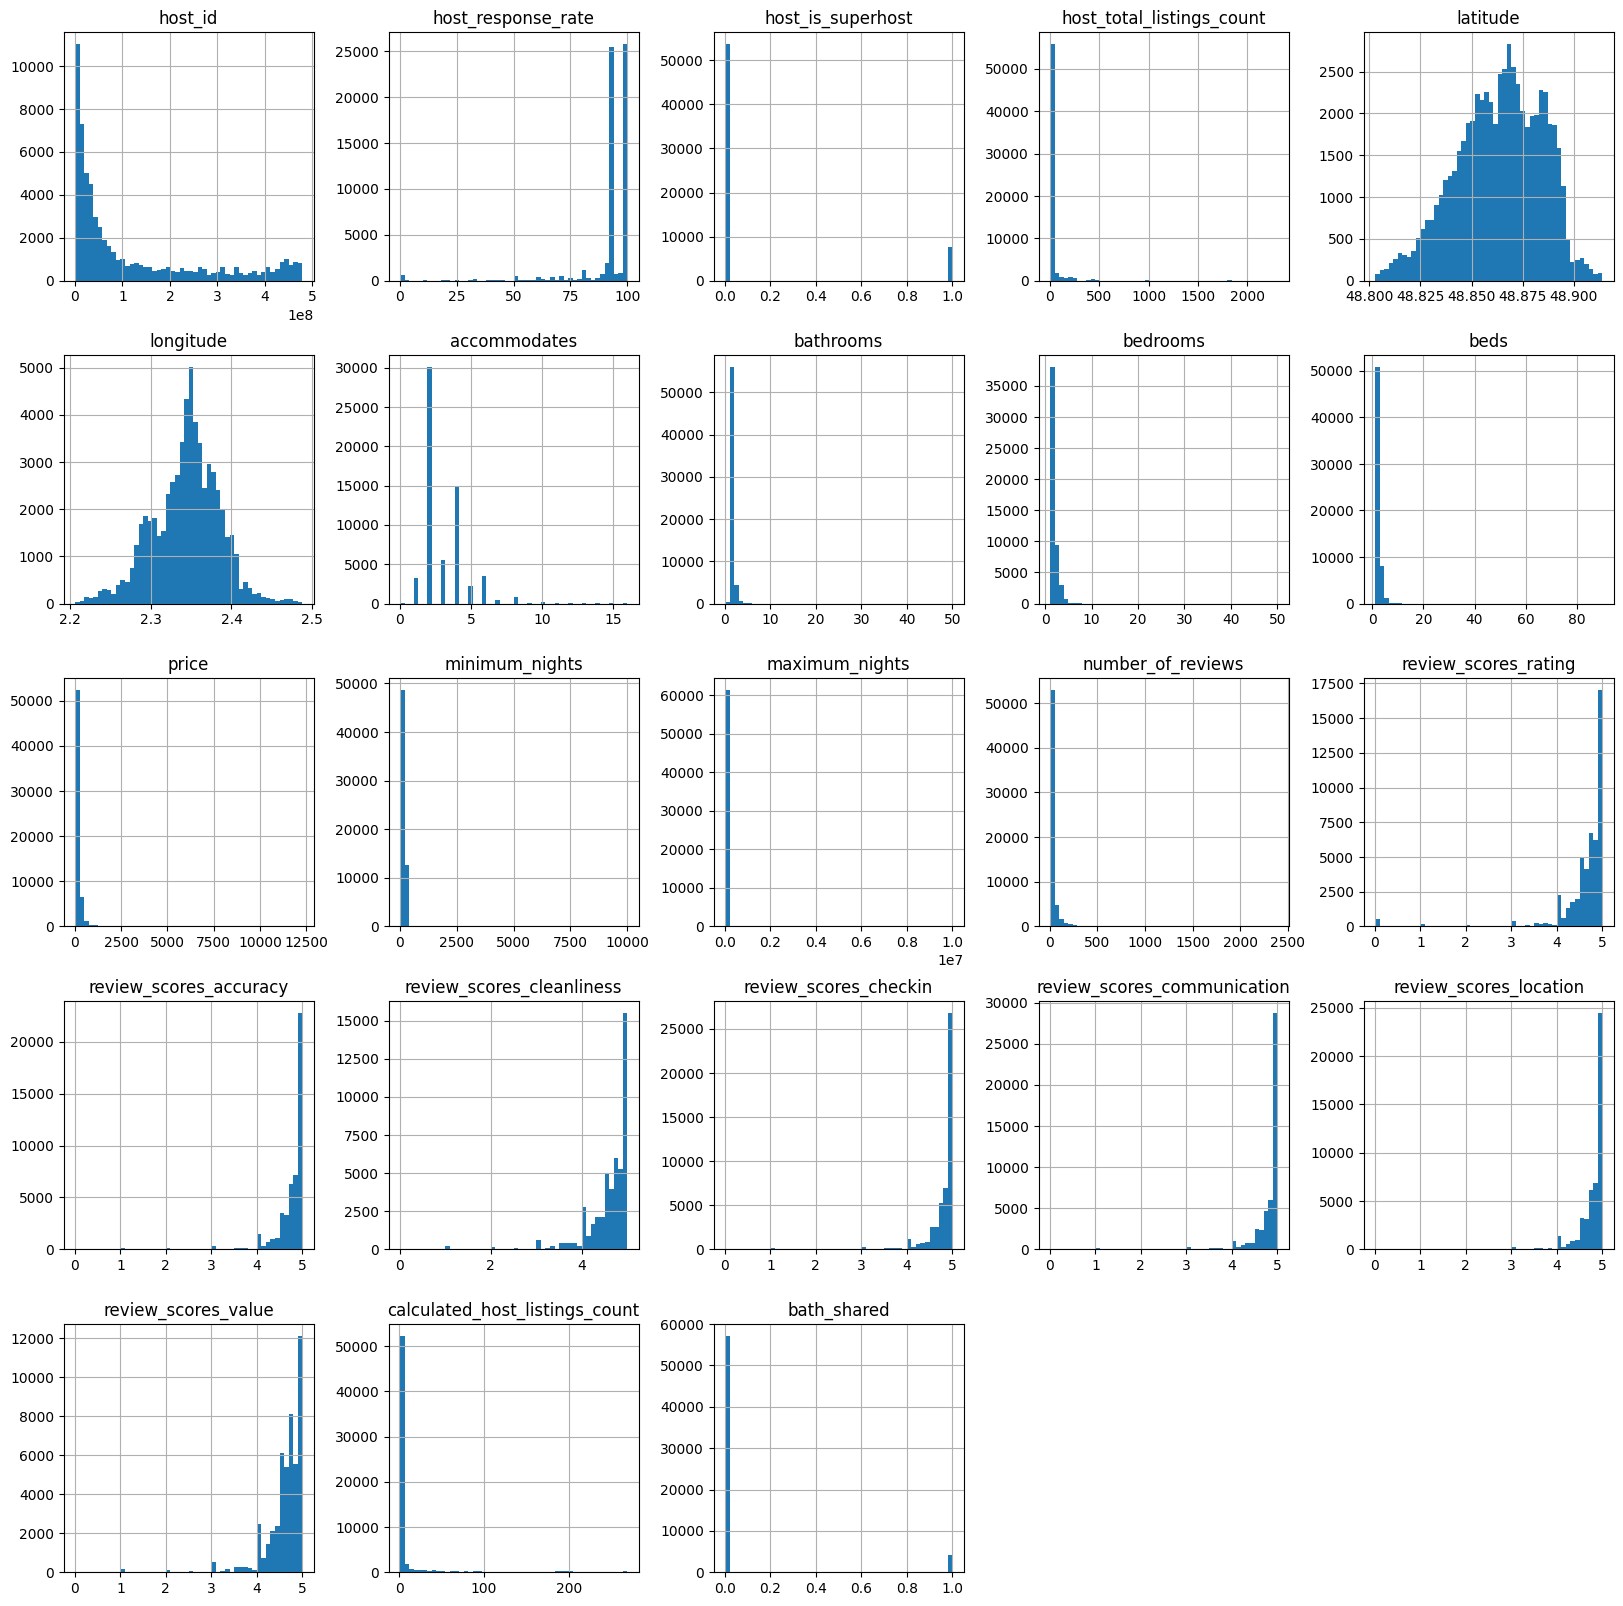

In [388]:
# plt.figure(figsize=(20, 30))
listings.hist(figsize=(20, 20), bins=50)
plt.title("Histogram of all features")
plt.show()

## Property types
This categorical feature describes a building where particular accommodation is located. What types do we have in Paris?

In [120]:
print(f"There are {len(listings.property_type.unique())} unique values for property type feature")

There are 76 unique values for property type feature


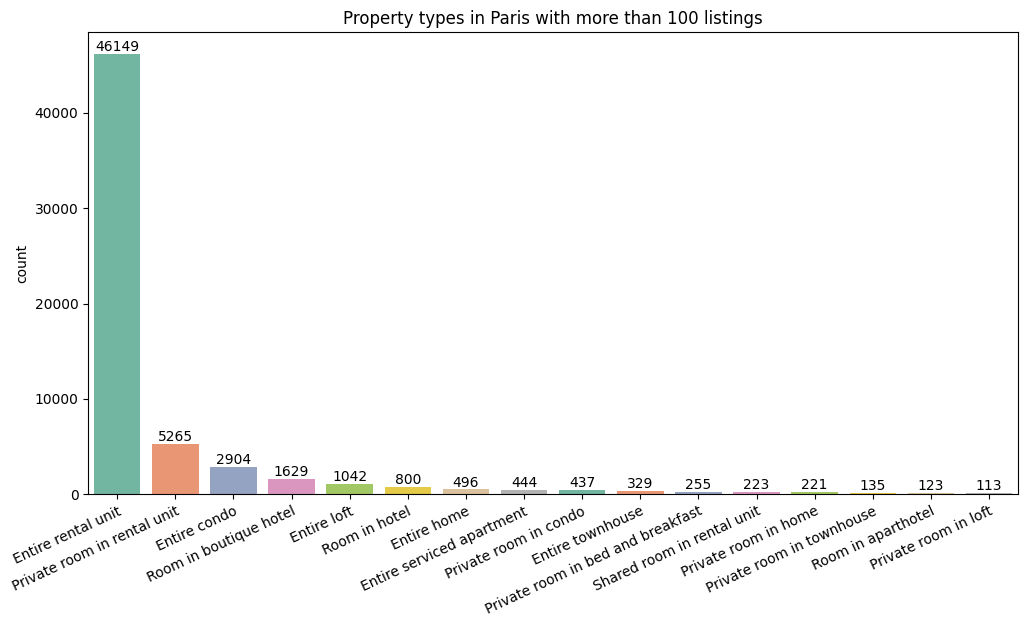

In [389]:
plt.figure(figsize=(12, 6))
pop_properties = listings.groupby("property_type").filter(lambda x: len(x) > 100).unstack()
ax = sns.countplot(pop_properties, 
              x="property_type", 
              order = pop_properties['property_type'].value_counts().index,
              palette="Set2")
for i in ax.containers:
    ax.bar_label(i,)
    
plt.xticks(rotation=25, ha='right', rotation_mode='anchor')
plt.title("Property types in Paris with more than 100 listings")
plt.show()

In [122]:
listings.groupby("property_type").filter(lambda x: len(x) <= 100).property_type.value_counts()

Private room in casa particular       69
Entire vacation home                  58
Entire guesthouse                     55
Private room in guesthouse            51
Private room in hostel                50
Shared room in home                   42
Private room                          39
Shared room in hostel                 38
Entire place                          33
Tiny home                             32
Shared room in condo                  32
Entire guest suite                    30
Private room in guest suite           29
Entire villa                          28
Private room in serviced apartment    25
Room in serviced apartment            23
Room in bed and breakfast             19
Houseboat                             17
Shared room in bed and breakfast      12
Boat                                  12
Private room in vacation home          9
Private room in houseboat              7
Shared room in loft                    7
Private room in villa                  6
Entire home/apt 

Dataset seems to be realistic. And its property type distribution as well. But we have a lot of property types, and we will need to process them somehow.

## Room types

This categorical feature represent 4 types of accommodation available on https://www.airbnb.com
1) Entire home or apartment
2) Private room in apartment
3) Hotel room
4) Shared room in apartment

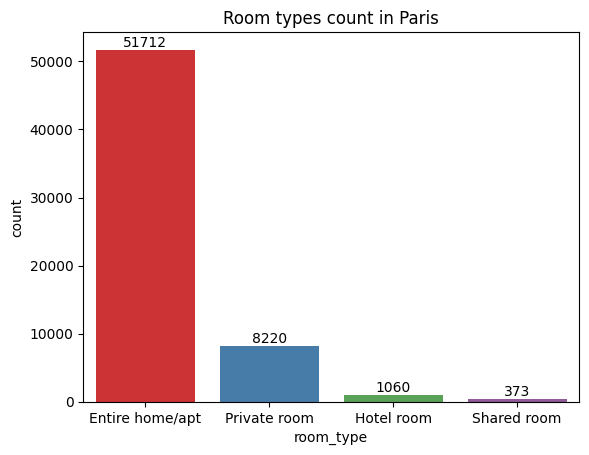

In [390]:
ax = sns.countplot(data=listings, 
              x="room_type", 
              palette="Set1", 
              order = listings['room_type'].value_counts().index)
for i in ax.containers:
    ax.bar_label(i,)
plt.title("Room types count in Paris")
plt.show()

### Neighbourhood
Let's start with exploring what **neighbourhoods** are presented and how many listings there are.

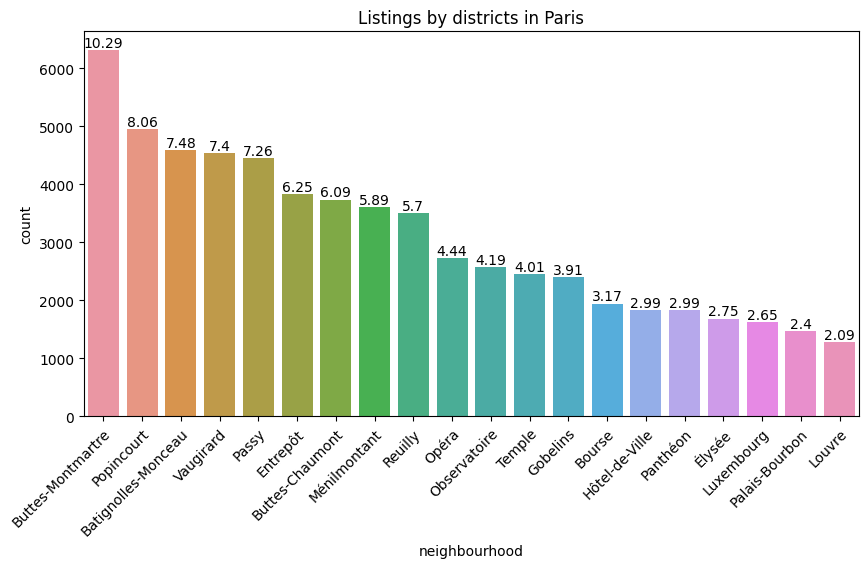

In [131]:
fig, ax = plt.subplots(figsize=(10, 5))
out_of_total = np.round(listings.neighbourhood.value_counts().values / len(listings) * 100, 2)
ax = sns.countplot(x = 'neighbourhood',
              data = listings,
              order = listings["neighbourhood"].value_counts().index, ax=ax)

for j in ax.containers:
    ax.bar_label(j, labels=out_of_total)

plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.title("Listings by districts in Paris")
plt.show()

We can see that Monmartre provide the highest amount of listings. Others regions may equally be grouped in intervals from 4000 to 5000, from 3000 to 4000, from 2000 to 3000 and others. 

Let's check what accommodation types (or **room type**) are presented in our listings' dataset in each of districts.

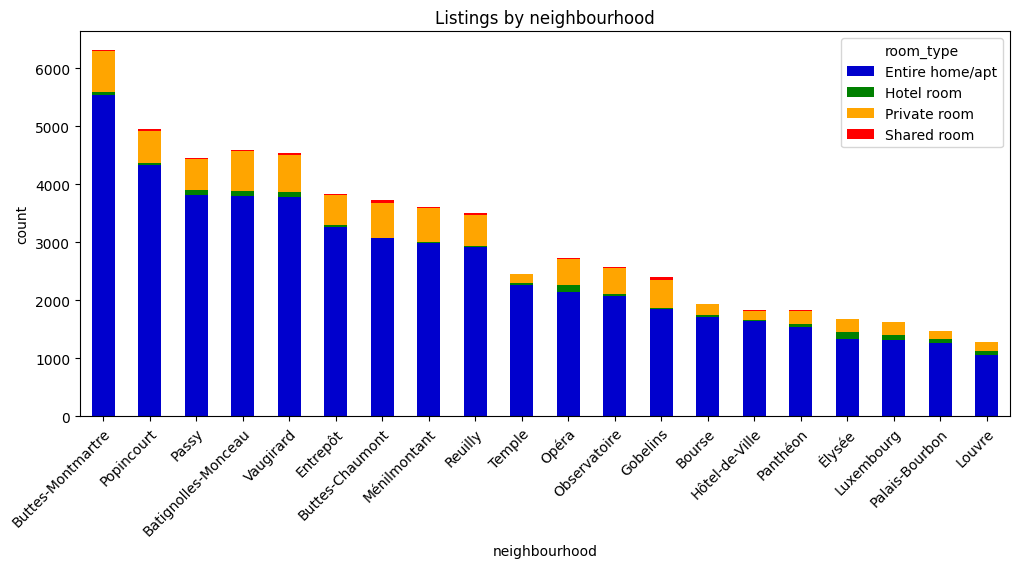

In [132]:
groups = listings[['neighbourhood', 'room_type', 'id']].groupby(['neighbourhood'])
groups.room_type.value_counts().unstack().sort_values(by='Entire home/apt',
                                                      ascending=False).plot(kind='bar', 
                                                                            stacked=True, 
                                                                            figsize=(12, 5),
                                       color=['mediumblue','green','orange', 'red'])

plt.ylabel("count")
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.title("Listings by neighbourhood")
plt.show()

We can see that in each district **entire home or apartment** listing type represent **absolute majority** of listings. Private rooms take second place while shared rooms and hotels rooms are in the not really meaningful minority.

Now let's check how district and room type affect price per night – our target variable.

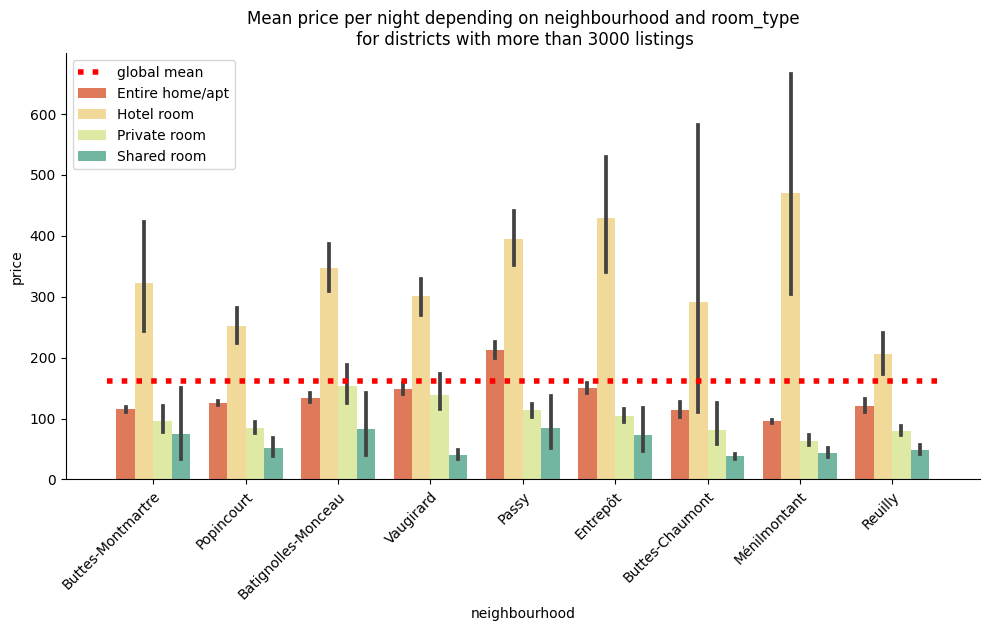

In [171]:
top_districts = listings.groupby('neighbourhood').filter(lambda x : len(x) > 3000)
mean_price = listings.price.mean()
sns.catplot(
    data=top_districts,
    x='neighbourhood',
    y='price',
    hue='room_type',
    kind='bar',
    aspect=2,
    order = top_districts.neighbourhood.value_counts().index, 
    palette="Spectral", 
    legend=None)
plt.plot([-0.5, 8.5], [mean_price, mean_price], 
         color='red', linestyle='dotted', linewidth=4, label="global mean")
plt.title("Mean price per night depending on neighbourhood and room_type\n for districts with more than 3000 listings")
plt.legend(loc="upper left")
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

How different is standard deviation for hotel room price depending on district!

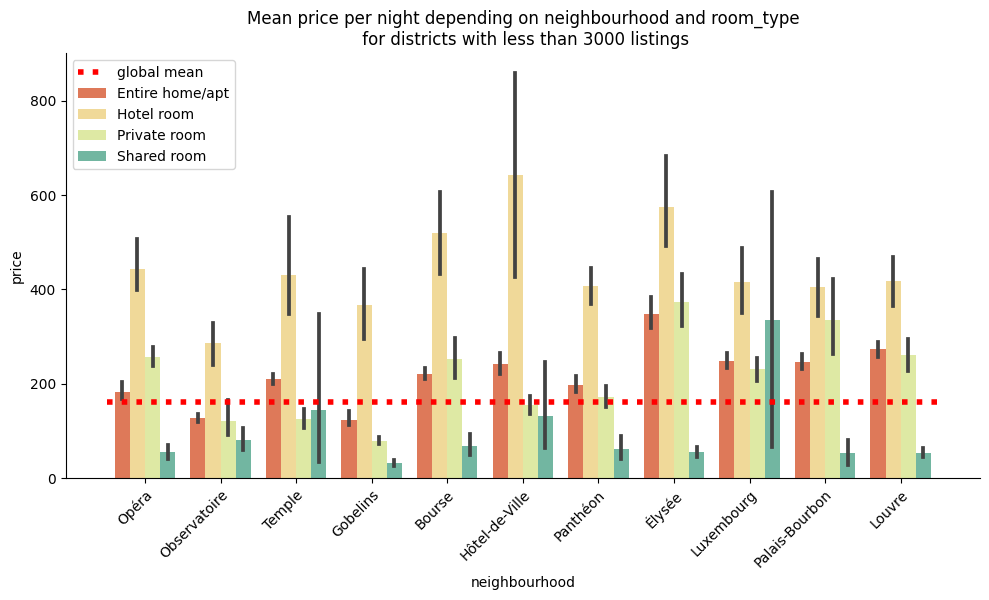

In [172]:
bot_districts = listings.groupby('neighbourhood').filter(lambda x : len(x) <= 3000)

sns.catplot(
    data=bot_districts,
    x='neighbourhood',
    y='price',
    hue='room_type',
    kind='bar',
    aspect=2,
    order = bot_districts.neighbourhood.value_counts().index, 
    palette="Spectral", 
    legend=None)
plt.plot([-0.5, 10.5], [mean_price, mean_price], color='red', linestyle='dotted', linewidth=4, label="global mean")
plt.title("Mean price per night depending on neighbourhood and room_type\n for districts with less than 3000 listings", )
plt.legend(loc="upper left")
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

And again we can see really curious trends on **data variation**. In Luxembourg district it is possible to find both a shared room for 50 € and 600 € per night.

Let's now explore how price depends on property type.

### Property type
This categorical feature has 76 values. Let's take a look on those that are mentioned more than 30 times in Paris listings.

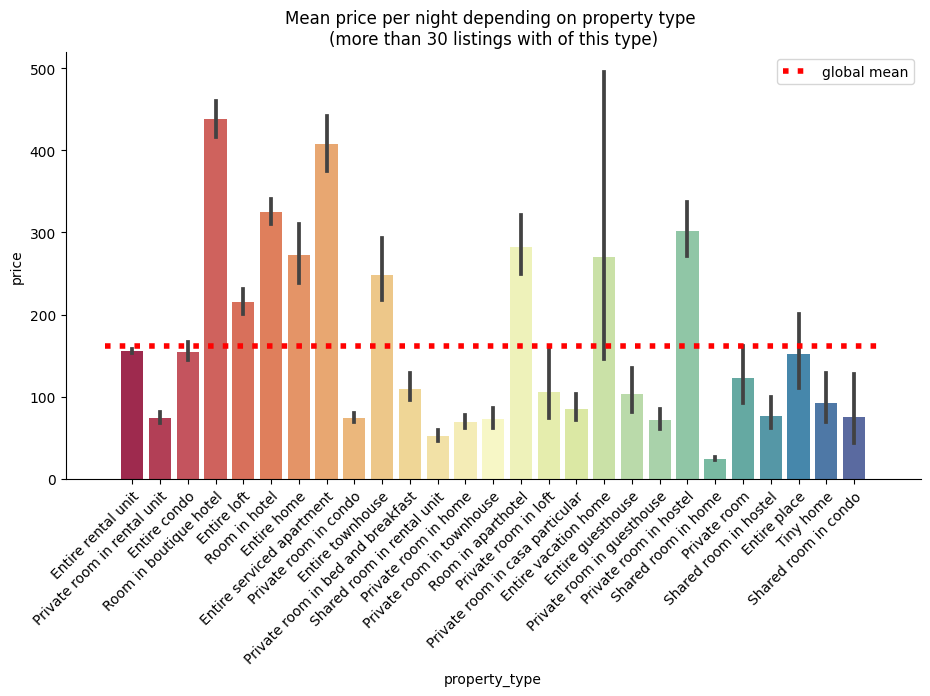

In [189]:
pop_properties = listings.groupby('property_type').filter(lambda x : len(x) > 30)
mean_price = listings.price.mean()
sns.catplot(
    data=pop_properties,
    x='property_type',
    y='price',
    kind='bar',
    aspect=2,
    order = pop_properties.property_type.value_counts().index, 
    palette="Spectral")
plt.plot([-1, 27], [mean_price, mean_price], color='red', linestyle='dotted', linewidth=4, label="global mean")
plt.legend()
plt.title("Mean price per night depending on property type \n(more than 30 listings with of this type)")
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

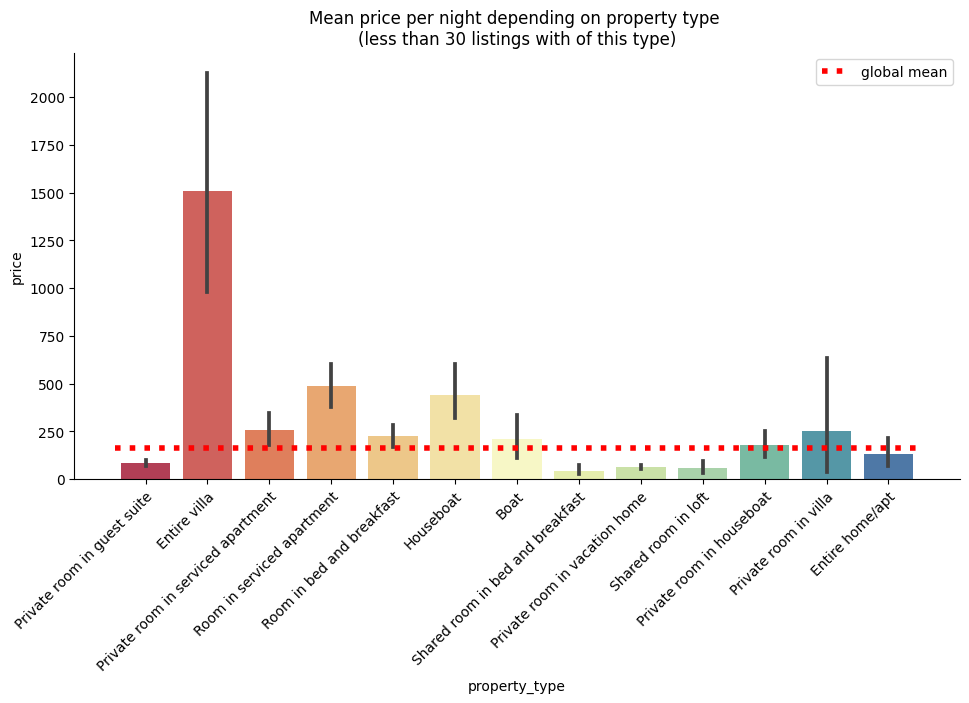

In [199]:
pop_properties = listings.groupby('property_type').filter(lambda x : 5 < len(x) < 30)
mean_price = listings.price.mean()
sns.catplot(
    data=pop_properties,
    x='property_type',
    y='price',
    kind='bar',
    aspect=2,
    order = pop_properties.property_type.value_counts().index, 
    palette="Spectral")
plt.plot([-0.5, 12.5], [mean_price, mean_price], color='red', linestyle='dotted', linewidth=4, label="global mean")
plt.legend()
plt.title("Mean price per night depending on property type \n(less than 30 listings with of this type)")
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

In [200]:
listings.price.describe()

count    61365.000000
mean       161.811326
std        301.441306
min          0.000000
25%         70.000000
50%        100.000000
75%        170.000000
max      12286.000000
Name: price, dtype: float64

Since the fact that property types along axis X are ordered according to their frequency in listings dataset, we can see that there is no dependency between these two factors.

But these visualisations prove several important points:
- Living in private villa or boat accommodations is very expensive
- Renting a part of accommodation is cheaper
- Global mean price reaches 161€ per night
- But in the same time median price is way lower: 100€ per night

But that is the case when the mean value is not a good choice to describe our data. Let's take a look on price distribution using histogram.

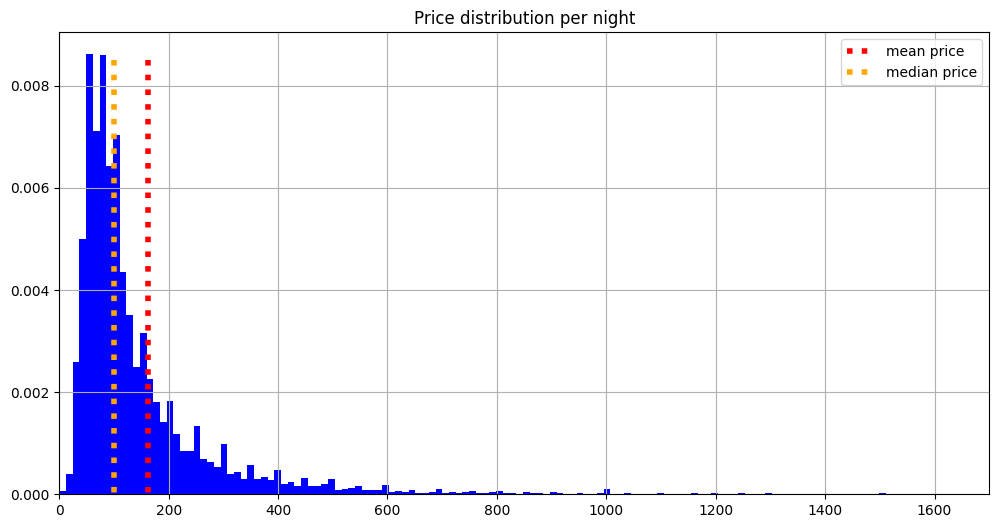

In [403]:
median_price = listings.price.median()
mean_price = listings.price.mean()
plt.figure(figsize=(12, 6))
listings.price.hist(bins=1000, color='b', density=True)
plt.plot([mean_price, mean_price], [0.0085, 0], color='red', linestyle='dotted', linewidth=4, label="mean price")
plt.plot([median_price, median_price], [0.0085, 0], color='orange', linestyle='dotted', linewidth=4, label="median price")
plt.title("Price distribution per night")
plt.legend()
plt.xlim([0, 1700])
plt.show()

We can conclude that price per night is chi-square distributed value with mean = 161 and std = 301.

### Amount of accommodates
This number will evidently affect the target price. But in what way?

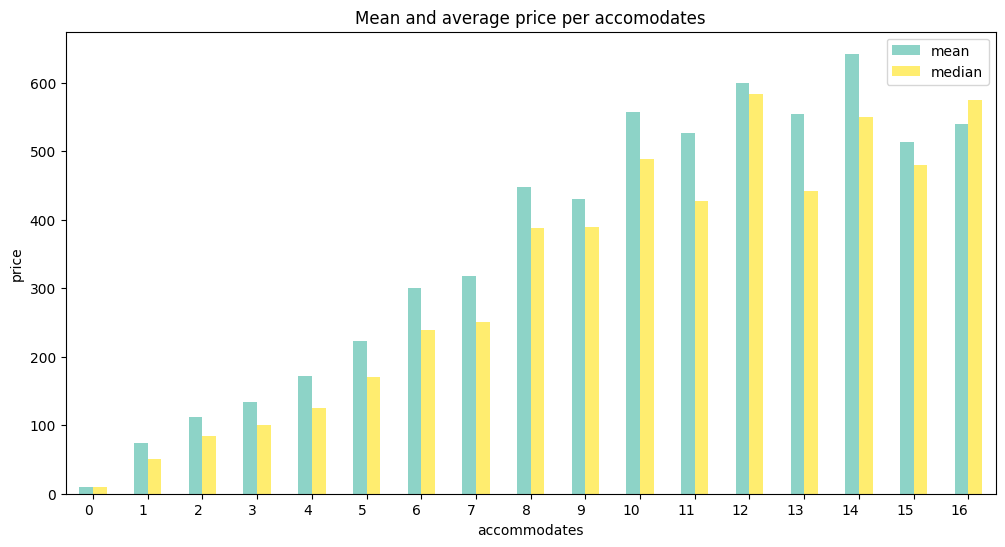

In [382]:
listings.groupby('accommodates').price.agg(["mean", "median"]).plot(kind='bar', cmap="Set3", figsize=(12, 6))
plt.xticks(rotation = 0,  ha='right', rotation_mode='anchor')
plt.ylabel("price")
plt.title("Mean and average price per accommodates")
plt.show()

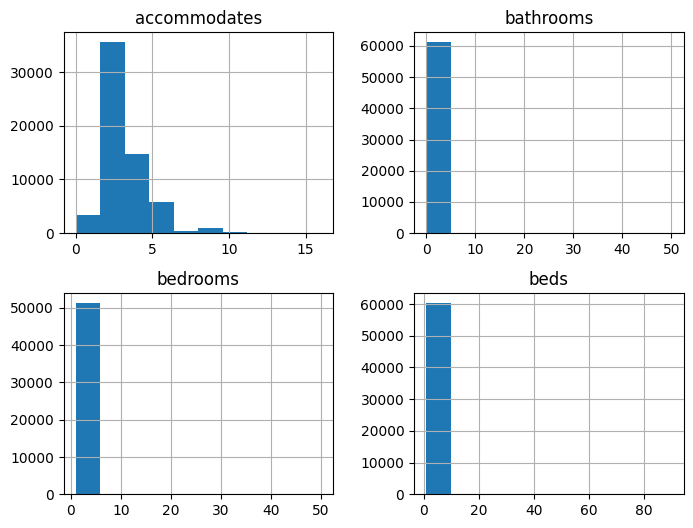

In [391]:
listings[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(8,6));

In [340]:
listings.columns

Index(['id', 'host_id', 'host_response_rate', 'host_is_superhost',
       'host_total_listings_count', 'neighbourhood', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count', 'bath_shared'],
      dtype='object')

### Host metrics

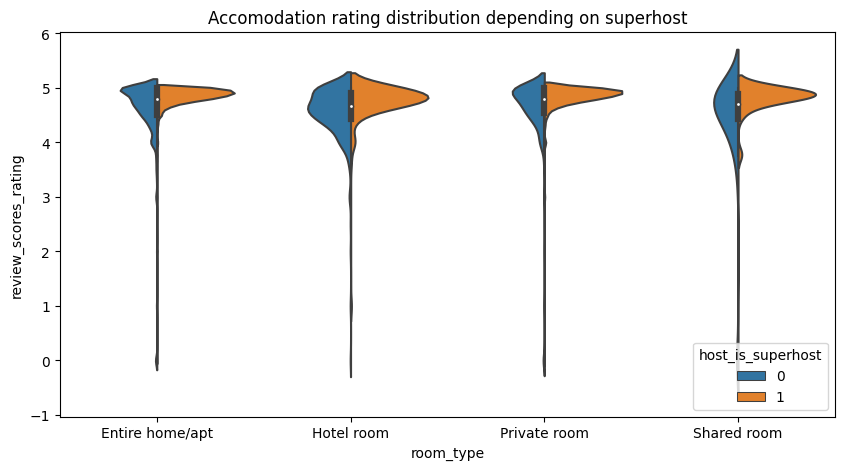

In [349]:
plt.figure(figsize=(10, 5))
sns.violinplot(x='room_type',
               y='review_scores_rating', 
               hue='host_is_superhost',  
               split=True, 
               data=listings)
plt.title("Accommodation rating distribution depending on superhost")
plt.show()

### Feature correlation map

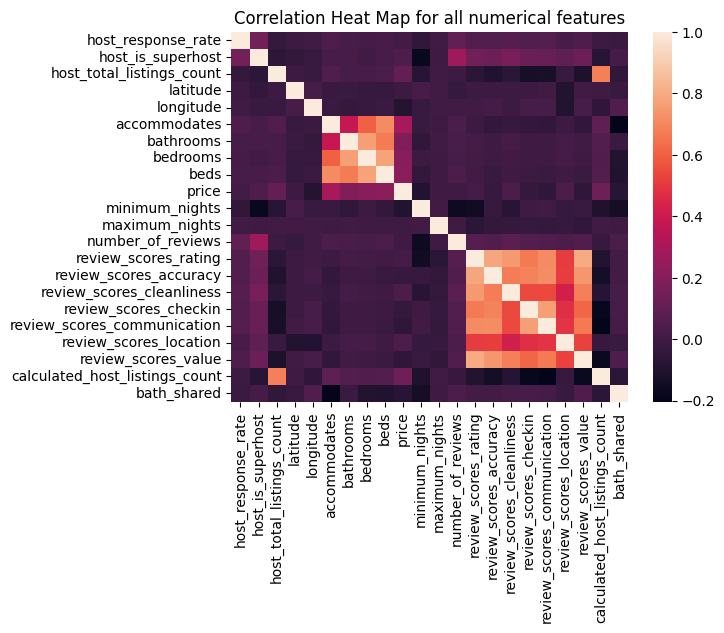

In [339]:
sns.heatmap(listings.drop(columns=["id", "host_id"]).select_dtypes(include=np.number).corr())
plt.title("Correlation Heat Map for all numerical features")
plt.show()

Actually we can not find out any new information from this heatmap. We can see two "squares" of high correlation:
1) Between accommodates, beds, bathrooms and price. This seems really logical, the bigger space, the more accommodates can rent an apartment, the higher price is.
2) Between all reviews scores, which seems correct as well.

### What can we do with other categorical features?
There are a lot of non-numeric data left. We need to encode it somehow without losing meaning of columns. One column which will be quite difficult to parse is amenities feature. It has a lot of values, if we encode them using one hot encoding, we will have enormous amount of columns.

In [404]:
listings.amenities

id
130420                ["Ethernet connection", "Hair dryer", "Hangers...
23441                 ["Heating", "Hair dryer", "Cooking basics", "S...
5396                  ["Hair dryer", "Toaster", "Hangers", "Kitchen"...
132994                ["Heating", "Elevator", "Smoke alarm", "Kitche...
7397                  ["Dryer", "Hair dryer", "Hangers", "Kitchen", ...
                                            ...                        
53622294              ["Heating", "Bed linens", "Elevator", "Smoke a...
557165022449478347    ["Hair dryer", "Central heating", "Hangers", "...
18725966              ["Ethernet connection", "Dryer", "Hair dryer",...
639704939422534275    ["Hair dryer", "Toaster", "Hangers", "Kitchen"...
53624999              ["Dryer", "Hair dryer", "Hangers", "Kitchen", ...
Name: amenities, Length: 61365, dtype: object

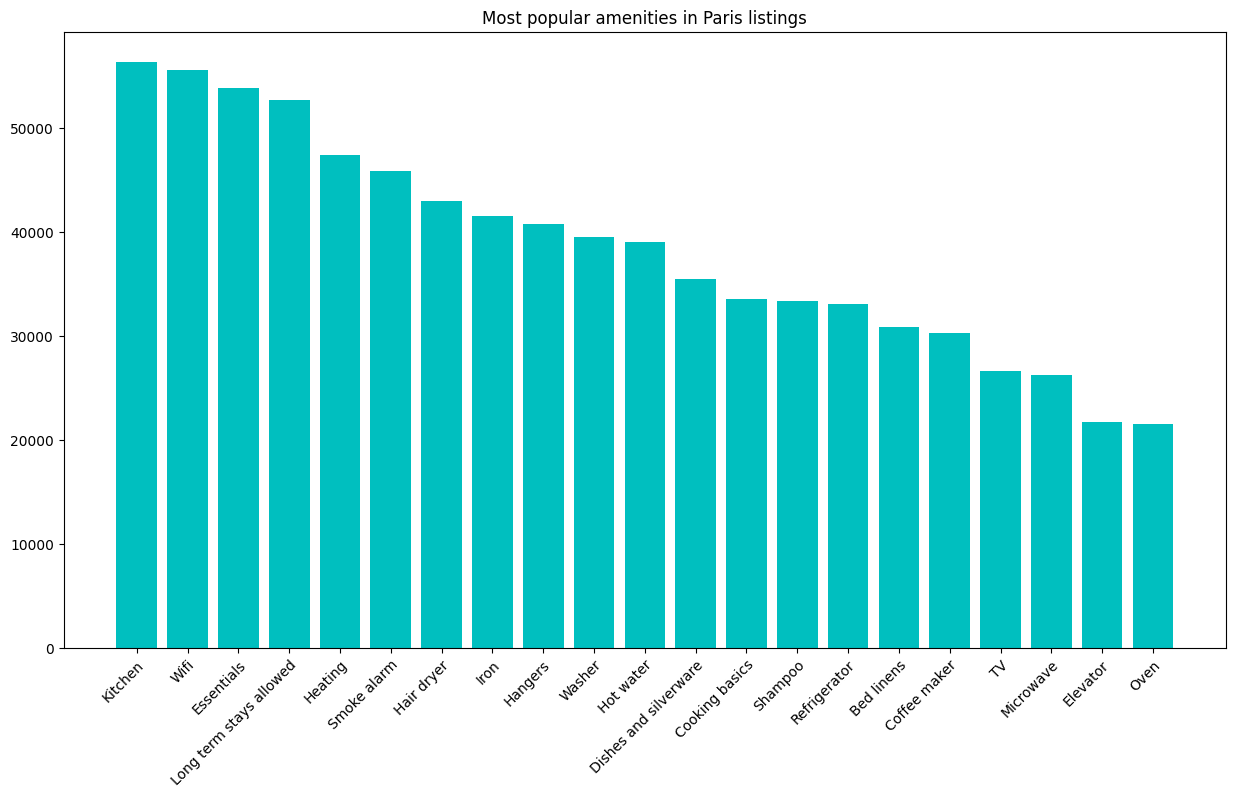

In [405]:
all_amenities = dict()
i = 0
for line in zip(listings.amenities.values, listings.room_type.values):
    room_t = line[1]
    for elem in line[0].replace("[", "").replace("]", "").split(", "):
        word = elem.replace('"', "")
        if word not in all_amenities.keys():
            all_amenities[word] = 1
        else:
            all_amenities[word] += 1
amenities = {k: v for k, v in all_amenities.items() if v > 20000}
amenities = dict(sorted(amenities.items(), key=lambda elem_amenity: elem_amenity[1], reverse=True))
plt.figure(figsize=(15, 8))
plt.bar(amenities.keys(), amenities.values(), color="c")
plt.xticks(rotation = 45,  ha='right', rotation_mode='anchor')
plt.title("Most popular amenities in Paris listings")
plt.show()

In [223]:
print(f"In total there are {len(all_amenities)} different amenities that were mentioned in listings")

In total there are 4558 different amenities that were mentioned in listings


And we will need to encode them somehow...

# Calendar dataset

This dataset contains 365 rows for each listing corresponding to the price change through the year. This is really important to explore and to implement insights to our future predicting model. Let's start from concatenating listings and calendars datasets.

In [288]:
cals = pd.read_csv("par_calendar.csv")
cals.rename(columns={"listing_id":"id"}, inplace=True)
cals.price.replace(",", "", inplace=True, regex=True)
cals.price = cals.price.apply(lambda row: float(str(row)[1:]))
cals.shape

(22395704, 7)

In [289]:
subset = listings[["id", "property_type", "room_type", "neighbourhood"]]
df = pd.merge(subset, cals, how='inner', on='id')
df.date = pd.to_datetime(df['date'])

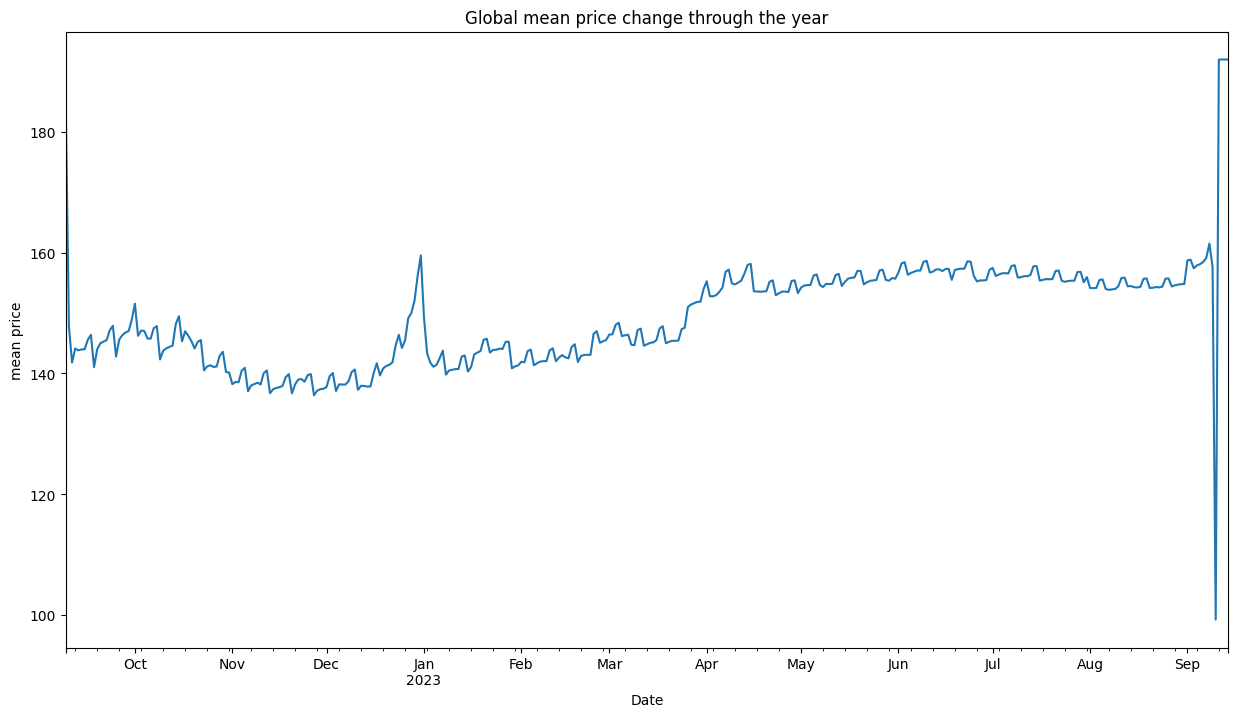

In [310]:
plt.figure(figsize=(15, 8))
df.groupby("date")["price"].mean().plot()
plt.xlabel("Date")
plt.ylabel("mean price")
plt.title("Global mean price change through the year")
plt.show()

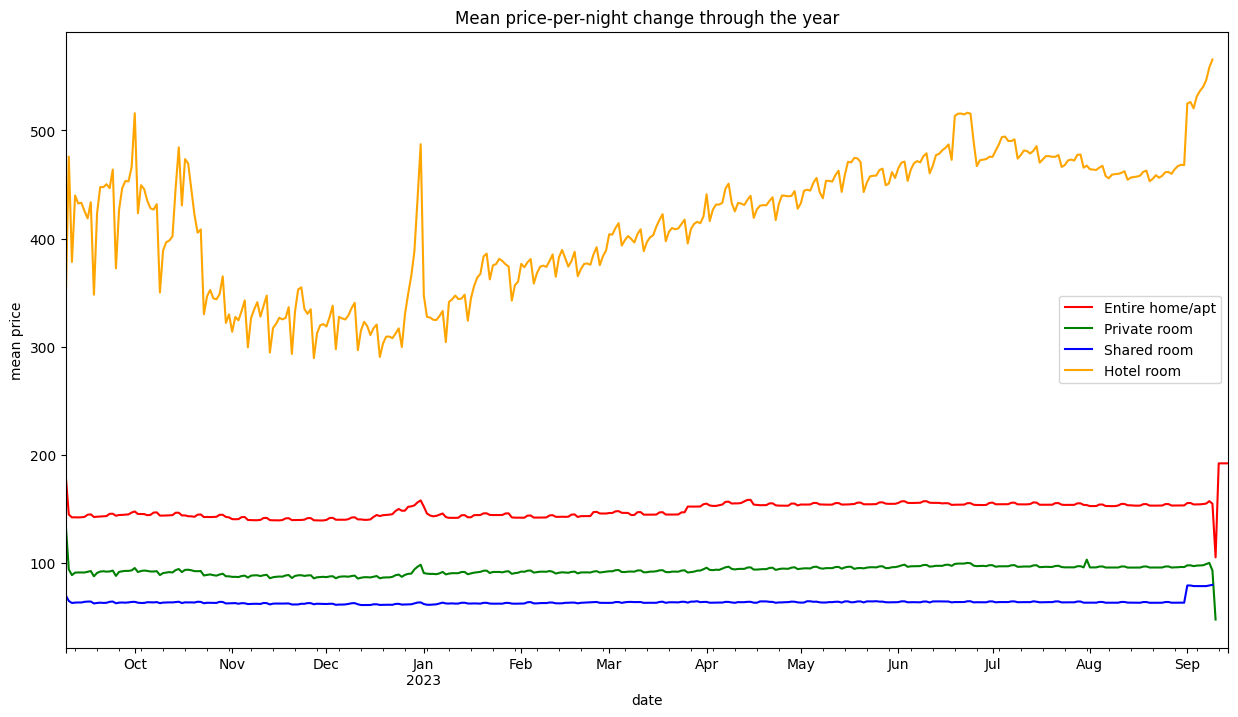

In [317]:
plt.figure(figsize=(15, 8))
colors = ["red", "green", "blue", "orange"]
i = 0
for elem in df.room_type.unique():
    cur = df[df["room_type"] == elem]
    cur.groupby(["date"])["price"].mean().plot(color=colors[i], label=elem)
    i += 1
plt.title("Mean price-per-night change through the year")
plt.ylabel("mean price")
plt.legend()
plt.show()

### Some insights:
1) Date does impact price-per-night value
2) Target values for hotel rooms varies more than that for others room types. But this results may also appear because of small amount of hotel rooms in dataset
3) We can see fluctuation along all plots around Christmas

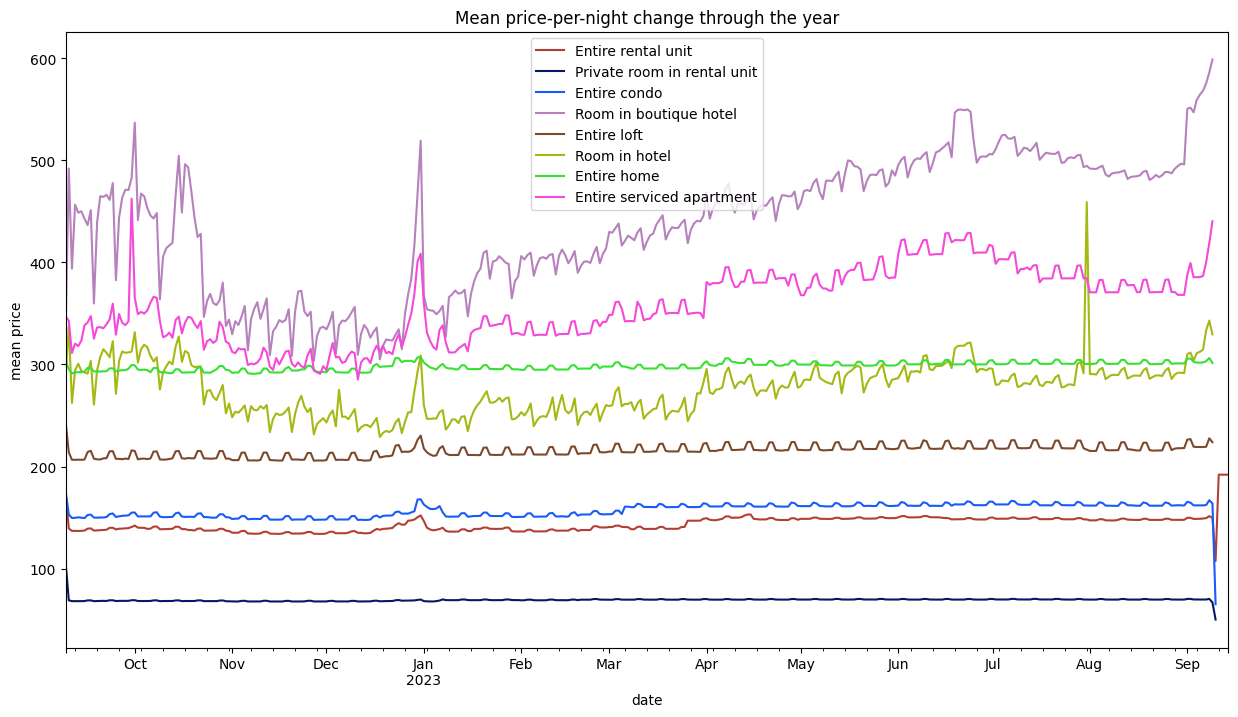

In [330]:
plt.figure(figsize=(15, 8))
colors = ["red", "green", "blue", "orange"]
for elem in df.property_type.value_counts().index[:8]:
    cur = df[df["property_type"] == elem]
    cur.groupby(["date"])["price"].mean().plot(c=np.random.rand(3,), label=elem)
plt.title("Mean price-per-night change through the year")
plt.ylabel("mean price")
plt.legend()
plt.show()

### Some insights from more detailed data:
- property types can be divided into 2 groups: the first one is more or less static through the year, another one fluctuates a lot and grows starting on March 22 approximately
- we can explicitly see how weekends increase price